# Developing intuition for fitting linear regression models

In [26]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


This notebook is inspired by Hadley Wickham's "Model Baiscs" chapter in his excellent "R for Data Science" book. Hadley Wickham is a legend. 

This is a python version that allows me to: 

* practise and learn python
* develop intuition for least squares estimation of linear models

We know about sklearn...we're doing this the long way **on purpose**

## Let's make up some stuff
First let's simulate some data that that have a generally linear relationship. These datasets will be meaningless.

We'll use sklearn's `make_regression` function for this. Let's make sure we understand it though. 


**`make_regression` explainer**: 

```sklearn.datasets.make_regression(n_samples=100, n_features=100, *, n_informative=10, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)```

`n_samples` = the number of data points to generate

`n_features` = how many features (independent variables / predictors) we want. We're doing simple linear regression, so one is all we want for now.

`noise` = If zero, the points all fall along the line of best fit. That's not much fun to fit, so we want to apply some randomness. Now, remember the assumptions of linear regression?... 

> **Assumption of Normality in errors (residuals)** The residuals (differences between observed and predicted values) should follow a normal distribution when considering multiple predictors together.

So the randomness needs to follow a gaussian distribution and the `noise` value is telling the function what the standard deviation of that distribution should be. 

`random_state` = This is just so we get the same data every time we run it. This function is generating random data, so if you were to repeat that process again, it's very unlikley you'd get the same output. This setting allows you to fix the randomness to a single state. It's the same as set.seed() in R. Watch this video for a fascinating background on the [generation of pseudorandom numbers](https://youtu.be/GtOt7EBNEwQ?si=hTS00pTn2Kj_bVyQ).



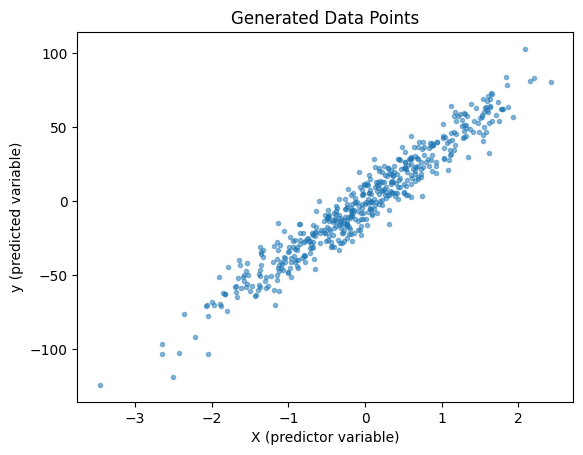

In [27]:
# generate simulated data points for linear regression modeling and plot them

from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500, n_features=1, noise=10, random_state=11)

plt.scatter(X, y, alpha=0.5, marker='.')
plt.title("Generated Data Points")
plt.xlabel("X (predictor variable)")
plt.ylabel("y (predicted variable)")
plt.show()


Next, let's put both columns of data (X and y) into a dataframe. 

First we inspect X and y and notice that X is 2D while y is 1D, so we have to handle them differently when we assign them as columns to our df. 

If we were running a multiple regression we would have multiple columns of "X" values ($X_1, X_2, etc...$)

In [28]:
X.shape, y.shape 

((500, 1), (500,))

In [29]:
df = pd.DataFrame(
    {
        'X': X[:, 0], 
        'y': y,
     }
)

df

,X,y
0,1.727191,67.068871
1,-0.217903,8.198985
2,0.370506,23.928870
3,-0.523088,-21.586658
4,-0.680973,-15.902727
...,...,...
495,-0.788715,-40.924310
496,-0.261961,-10.463544
497,-0.067669,-19.468546
498,0.593498,44.058731


Great. So we have some data and we put it into a dataframe... so now let's imagine that we can't see it, the plot above doesn't exist. How would we fit a line through it? How would we know which line has the best fit? 


## Fun little diversion
Note: why uppercase X and lowercase y?
Right now, we're doing *simple* linear regression, which uses just one predictor variable, X. But in future, we might want to add multiple predictor variables $X_1, X_2, X_3... X_n$ which means we need to "glue" columns together (sort of like using 4 columns of a spreadsheet instead of 1). A useful way to do this is to use Matrices -- so all columns go into a 1 x n matrix, that might look like this: 

$$
\begin{pmatrix}
  X_1 \\
  X_2 \\
  X_3 \\
  X_n
\end{pmatrix}
$$

In standard mathematical notation, upper case letters are used for matrices and lower case letters are used for vectors. Vectors are just lists of numbers like (1, 2, 3, 4). Matrices are lists of vectors, like ((1, 2, 3), (1, 1, 1), (3, 4, 5)).

So since X is often a matrix, it is uppercase. Since y will always be a vector, it's lowercase.

OK, back to finding the line of best fit. How might we do it without looking at the data? 


## Linear Models, but make it CHAOS

Well we know that there exists a line that best fits the data, because we built this into our assumption when we created the dataset using `make_regression`. We also know that the line will have an equation of the form $y = mx + c$ and we already know some values of x and y that fall on, or close to the line. 

So, let's start by making a bunch of lines and then work out how to tell which is best... 

Let's understand the "space" within which we're working. We can't go beyond the min and max of our data, so let's work out those first. 

In [30]:
# print the limits of our 2D space:
df_space_limits = df.agg(['min', 'max'], axis = 0)

df_space_limits

,X,y
min,-3.460283,-124.034071
max,2.420861,102.848164


In [31]:
df_space_limits.iloc[0, 1]

np.float64(-124.03407062581479)

Now let's create a series of lines that run straight across that space in different directsions...

We know the possible range of X and y values, so lets generate some random pairs of points based on those, and then draw lines through them. 

In [32]:
# generate random X and Y values using the df_space_limits as limits
num_models = 150

# xmin, xmax = df_space_limits["X"].min(), df_space_limits["X"].max()
# ymin, ymax = df_space_limits["y"].min(), df_space_limits["y"].max()

# set the min and max manually to allow some leeway outside of the real data
xmin = -4
xmax = 4
ymin = -150
ymax = 150

slope_range = 100

# generate random slopes & intercepts
rng = np.random.default_rng(123)
models = pd.DataFrame({
    "intercepts": rng.uniform(ymin, ymax, num_models),   # intercepts
    "slopes": rng.uniform(-slope_range, slope_range, num_models)         # slopes
})

models.head()

,intercepts,slopes
0,54.705559,-96.941350
1,-133.853694,-30.165263
2,-83.892038,31.862004
3,-94.688457,-46.956774
4,-97.228230,30.403768


Let's see what those models look like on a chart...

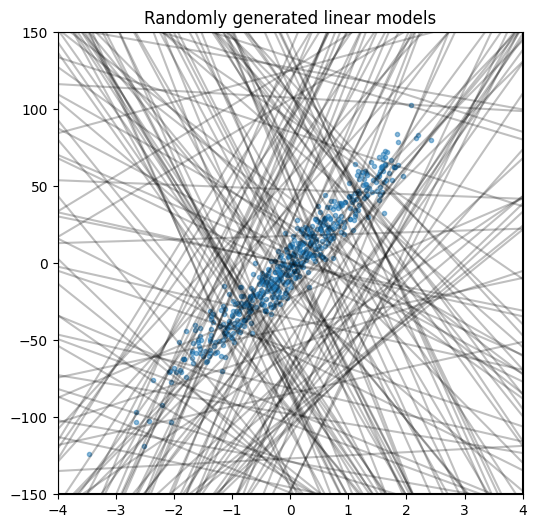

In [33]:

# x-values across the bounding box
x_vals = np.linspace(xmin, xmax, 100)

# plot
fig, ax = plt.subplots(figsize=(6,6))

# add the scatter points
plt.scatter(X, y, alpha=0.5, marker='.')

# apply the lines
for _, row in models.iterrows():
    y_vals = row["intercepts"] + row["slopes"] * x_vals # this is our linear formula
    ax.plot(x_vals, y_vals, color="black", alpha=0.25)

# draw bounding box
ax.plot([xmin, xmax, xmax, xmin, xmin],
        [ymin, ymin, ymax, ymax, ymin],
        color="black")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_title("Randomly generated linear models")
plt.show()




There are 150 models on this plot, and a lot are really bad. But a few look ok... maybe? We *could* find the line, but remember, we're not doing that visually... we're still pretending we can't see the data... So how do we tell if these lines are a good fit or not? 

One logical first step might be to calculate the vertical distance between each data point and the line. So let's do that for one of our models...

So if we're doing the vertical distance from each data point, then we already know $x$, and from the model we know $m$ and $c$, so all we need to do is calculate $y$ for each data point, and compare it to the actual value of $y$. 

So let's pick a model randomly, and compare it to each data point. Here, we're calculating the **"residuals"**, which just means "what's left after you take the predicted value away from the actual value. 

$$ residuals = y_{actual} - y_{predicted}$$


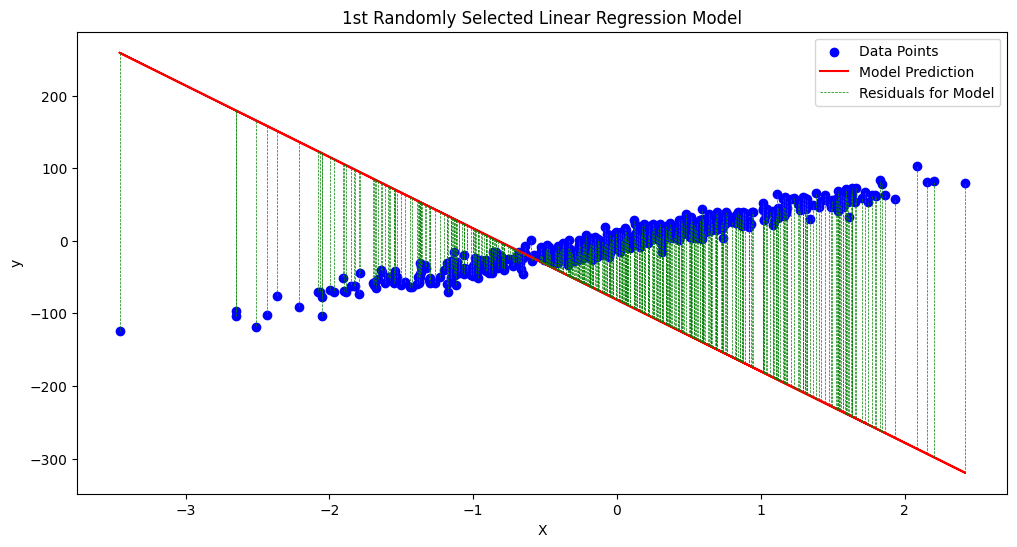

In [34]:

import random

random.seed(38449)

# pick a random model
rand_mod = random.randint(0, num_models)


# Generate the predicted y values based on the model that we randomly selected
df['y_pred'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']

# Calculate the residuals
df['residuals1'] = df['y'] - df['y_pred']

# plot the model line, the data points, and the residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label=f'Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'1st Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

Beautiful! Just kidding... interesting though. Let's try another one...  

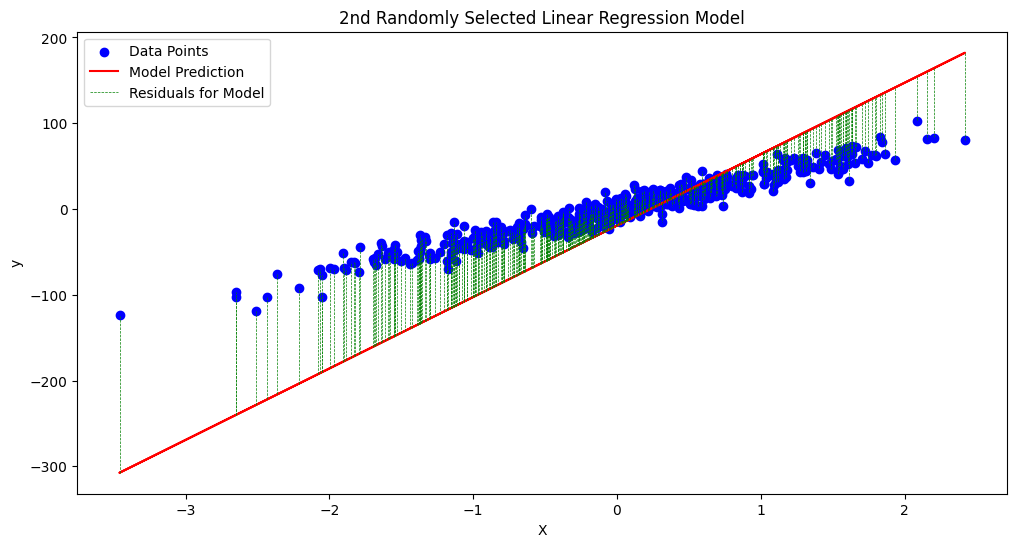

In [35]:

random.seed(45)  #45. All too high: 14. Best: 667

# pick a random model
rand_mod = random.randint(0, num_models)

# Generate the predicted y values based on the model that we randomly selected
df['y_pred2'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']

# Calculate the residuals
df['residuals2'] = df['y'] - df['y_pred2']

# plot the model line, the data points, and the residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred2'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred2'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label=f'Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'2nd Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

Bit better...Let's do one more...

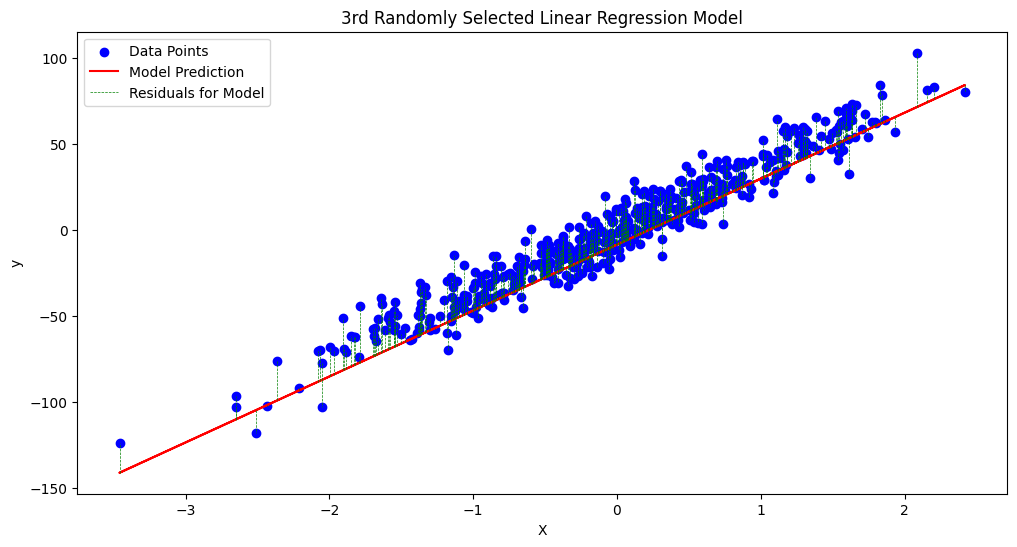

In [36]:
random.seed(667)  #45. All too high: 14. Best: 667

# pick a random model
rand_mod = random.randint(0, num_models)

# Generate the predicted y values based on the model that we randomly selected
df['y_pred3'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']

# Calculate the residuals
df['residuals3'] = df['y'] - df['y_pred3']

# plot the model line, the data points, and the residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred3'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred3'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label=f'Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'3rd Randomly Selected Linear Regression Model')
plt.legend()
plt.show()

NICE!

But... I need a way to quantify "NICE!". We can see that less green => better, so let's sum up the "green" (residuals) for each model and compare those. 

## Quantifying "NICE!"

In [37]:

df[['residuals1', 'residuals2', 'residuals3']].agg(['count', 'sum'], axis = 0)


,residuals1,residuals2,residuals3
count,500.000000,500.000000,500.000000
sum,38414.375716,10425.800622,4313.193625


Alright, so: 

* our 1st randomly selected model has a sum of residuals of 38414
* our 2nd randomly selected model has a sum of residuals of 10426 (lower than 1) 
* our 3rd randomly selected model has a sum of residuals of 4313 (lower than 1 and 2)

So now we have a number that tells us that 3rd model is better... BUT... what if the data aren't so perfect and we have big outliers. What if we were able to find a model that had huge residuals but because they are positive AND negative, they cancel out? 

We need something more robust...  

How about the average?

In [38]:

df[['residuals1', 'residuals2', 'residuals3']].agg(['count', 'sum', 'mean'], axis = 0)


,residuals1,residuals2,residuals3
count,500.000000,500.000000,500.000000
sum,38414.375716,10425.800622,4313.193625
mean,76.828751,20.851601,8.626387


Well that actually makes it harder to tell the difference between the models. I think we can all agree that model 1 is the worst, but the difference between model 1 and model 3 is only 68 points, not a lot. 

## Be there or be square

So, this is where a little math background comes in... I feel like I might have invented this method myself (eventually), but how about we just accept a little help from the last 3000 years of mathematical endeavour? Be a shame to waste all that effort, wouldn't it. 

... If we multiply each residual by iteself (square it) then the bigger numbers get MUCH bigger, while the smaller numbers stay REAL SMALL. We also make negative numbers positive, which means that averaging them won't cause postitive and negative differences to cancel out. 

Watch... 

In [39]:

# square the residuals then sum them (adding other useful aggregations)
df[['residuals1', 'residuals2', 'residuals3']].pow(2).agg(['count', 'sum', 'mean', 'std'], axis = 0)



,residuals1,residuals2,residuals3
count,5.000000e+02,5.000000e+02,500.000000
sum,1.176542e+07,1.290983e+06,83422.099543
mean,2.353085e+04,2.581966e+03,166.844199
std,2.966120e+04,3.718513e+03,208.604995


Ok great -- now we can see fairly clearly that model 3 is best. 

So, now let's apply this logic to ALL the models and see which ouf our models is best... 

In [40]:
models.head()

,intercepts,slopes
0,54.705559,-96.941350
1,-133.853694,-30.165263
2,-83.892038,31.862004
3,-94.688457,-46.956774
4,-97.228230,30.403768


In [41]:

# revert our df back to the original 
df = pd.DataFrame(
    {
        'X': X[:, 0], 
        'y': y,
     }
)

# function to apply the squared error (residuals) calculation to every model in the list
def model_sse(row):
        y_pred = row['intercepts'] + row['slopes'] * df['X']
        residuals = df['y'] - y_pred
        sse = (residuals ** 2).sum()
        return pd.Series({
                'intercept': row['intercepts'],
                'slope': row['slopes'],
                'sse': sse, 
                'mse': sse / len(df), #mean squared error
                'rmse': np.sqrt(sse / len(df)) #root mean squared error
        })


# apply it to all models in the list
results = models.apply(model_sse, axis=1).reset_index(names='model_id')

results.head()



,model_id,intercept,slope,sse,mse,rmse
0,0,54.705559,-96.941350,1.037811e+07,20756.214664,144.070173
1,1,-133.853694,-30.165263,1.085433e+07,21708.661457,147.338595
2,2,-83.892038,31.862004,3.555813e+06,7111.626178,84.330458
3,3,-94.688457,-46.956774,7.631472e+06,15262.944563,123.543290
4,4,-97.228230,30.403768,4.763668e+06,9527.335105,97.608069


So...which is the best model out of our 150 random models? All we need to do is take the model with the smallest sse (or rmse) 

In [42]:
# find the best model (min sse)
best_model = results.nsmallest(1, 'sse')

best_model



,model_id,intercept,slope,sse,mse,rmse
83,83,-3.003589,39.348855,52623.236154,105.246472,10.25897


Let's plot that model and see how it looks. 

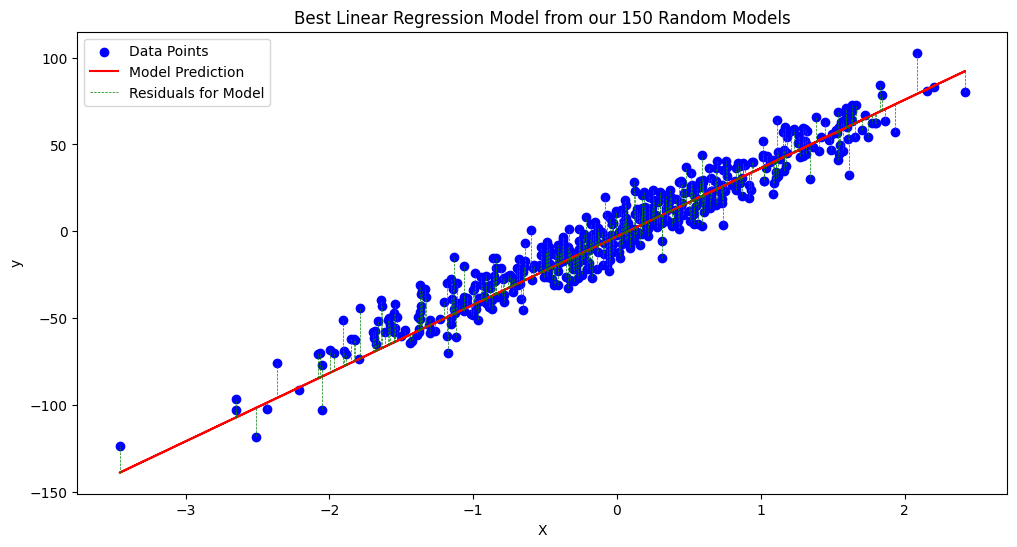

In [43]:

# pick a random model
rand_mod = best_model['model_id'].values[0]

# Generate the predicted y values based on the model that we randomly selected
df['y_pred'] = models.iloc[rand_mod]['intercepts'] + models.iloc[rand_mod]['slopes'] * df['X']

# Calculate the residuals
df['residuals1'] = df['y'] - df['y_pred']

# plot the model line, the data points, and the residuals
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['y'], color='blue', label='Data Points')
plt.plot(df['X'], df['y_pred'], color='red', label='Model Prediction')
plt.vlines(df['X'], df['y_pred'], df['y'], color='green', linestyle='dashed', linewidth=0.5, label=f'Residuals for Model')
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Best Linear Regression Model from our 150 Random Models')
plt.legend()
plt.show()

Here's a chart showing the all of the models by fit, according to thier slopes and intercepts

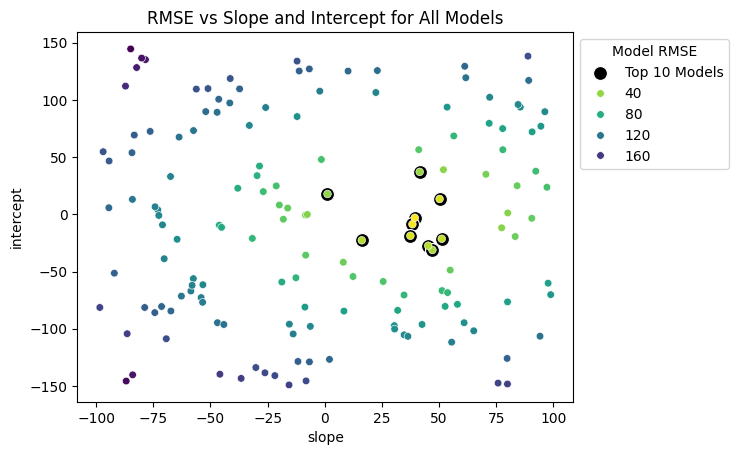

In [44]:

top_10_mods = results.nsmallest(10, 'rmse')

sns.scatterplot(data = top_10_mods, x = 'slope', y = 'intercept', color='black', s=100, label='Top 10 Models')
sns.scatterplot(data = results, x = 'slope', y = 'intercept', s=30, hue = 'rmse', palette='viridis_r')
plt.title('RMSE vs Slope and Intercept for All Models')
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1), title = "Model RMSE")
plt.show()


## But be organized about it

So until now we've been using randomly generated models. But we could be more systematic and use a method called grid search. This is where we generate a grid of evenly spaced models and then run the same distance measures. Here I picked slopes and intercepts based on the best models shown in the chart above...

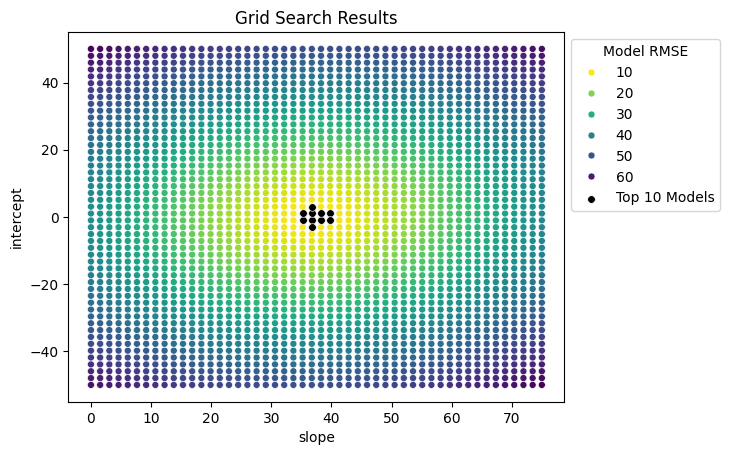

In [45]:

# reminder of the function
def model_sse(row):
        y_pred = row['intercepts'] + row['slopes'] * df['X']
        residuals = df['y'] - y_pred
        sse = (residuals ** 2).sum()
        return pd.Series({
                'intercept': row['intercepts'],
                'slope': row['slopes'],
                'sse': sse, 
                'mse': sse / len(df), #mean squared error
                'rmse': np.sqrt(sse / len(df)) #root mean squared error
        })

# make the grid
slopes = pd.DataFrame({"slopes": np.linspace(0, 75, 50)})
intercepts = pd.DataFrame({"intercepts": np.linspace(-50, 50, 50)})

grid = slopes.merge(intercepts, how="cross")

# Apply the fit to each model in the grid
grid_results = grid.apply(model_sse, axis=1).reset_index(names='model_id')
top_10_grid_results = grid_results.nsmallest(10, 'rmse')


sns.scatterplot(data = grid_results, x = 'slope', y = 'intercept', s=25, hue = 'rmse', palette='viridis_r')
sns.scatterplot(data = top_10_grid_results, x = 'slope', y = 'intercept', color='black', s=30, label='Top 10 Models')

plt.title('Grid Search Results')
plt.legend(loc = "upper left", bbox_to_anchor=(1, 1), title = "Model RMSE")
plt.show()



Pretty nice! So theoretically we could keep iterating on this grid search process to get the best model, BUT... would it be the BEST POSSIBLE model? Probably not.

## Optimially yours

In his R book, Hadley Wickham makes use of the Newson-Raphson search tool which is a numerical minimization tool. It picks a starting point and then looks around for the steepest slope (similar to, but not, gradient descent). Hadley uses `optim()` to run that. A little googling tells me that `scipy.optimize.minimize` is the equivalent. Let's play... 

In [46]:
from scipy.optimize import minimize


# revert our df back to the original 
df = pd.DataFrame(
    {
        'X': X[:, 0], 
        'y': y,
     }
)

# edit the function a little so that we just get a single value back
def model_rmse(params, X, y):
        intercept, slope = params
        y_pred = intercept + slope * X
        residuals = y - y_pred
        rmse = np.sqrt(np.mean(residuals ** 2))
        return rmse


# apply the optimization function
initial_guess = [0, 0]  # initial guess for intercept and slope
result = minimize(model_rmse, initial_guess, args=(df['X'], df['y']))

# extract the optimized parameters
optimized_intercept, optimized_slope = result.x


In [47]:
print(f"Our optimal model was found to have intercept: {optimized_intercept}, and slope: {optimized_slope}")

Our optimal model was found to have intercept: -0.07967232585388516, and slope: 36.9187345299132


Let's plot the model

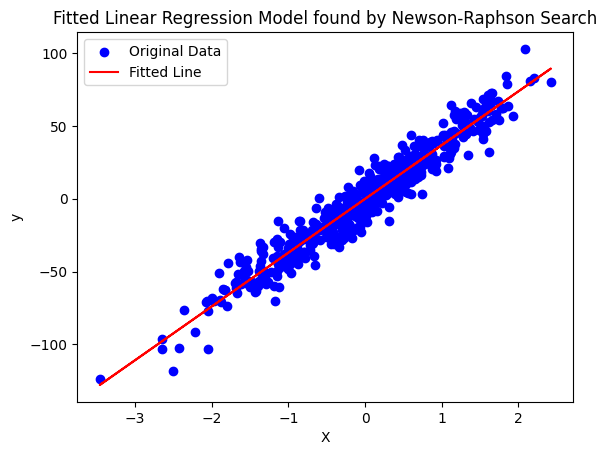

In [48]:
# plot the optimal model against the original X and y data

plt.scatter(df['X'], df['y'], color='blue', label='Original Data')
plt.plot(df['X'], optimized_intercept + optimized_slope * df['X'], color='red', label='Fitted Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Fitted Linear Regression Model found by Newson-Raphson Search')
plt.legend()
plt.show()




## Now do all that in three lines of code

Now let's do this using sklearn's LinearRegression tool and see how we did... 

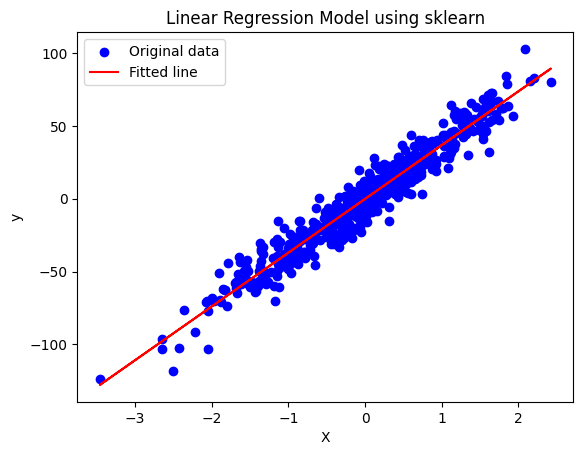

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# create a linear regression model 
lm = LinearRegression()

# fit the model
lm.fit(X, y)

# make predictions
y_pred = lm.predict(X)

# calculate the RMSE
rmse = root_mean_squared_error(y, y_pred)

# plot the model against the original data
import matplotlib.pyplot as plt

plt.scatter(X, y, color='blue', label='Original data')
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Model using sklearn')
plt.legend()
plt.show()



## We had fun, didn't we?

In [50]:

# get the value of the intercept from the best model (lowest rmse) from the top_10_grid_results

grid_search_intercept = top_10_grid_results.nsmallest(1, 'rmse')['intercept'].values[0]
grid_search_slope = top_10_grid_results.nsmallest(1, 'rmse')['slope'].values[0]

print(f"Our optimal model using coarse grid search was found to have:   intercept: {grid_search_intercept:.4f}, and slope: {grid_search_slope:.2f}")
print(f"Our optimal model using Newson-Raphson was found to have:       intercept: {optimized_intercept:.4f}, and slope: {optimized_slope:.2f}")
print(f"Our optimal model using sklearn was found to have:              intercept: {lm.intercept_:.4f}, and slope: {lm.coef_[0]:.2f}")



Our optimal model using coarse grid search was found to have:   intercept: -1.0204, and slope: 36.73
Our optimal model using Newson-Raphson was found to have:       intercept: -0.0797, and slope: 36.92
Our optimal model using sklearn was found to have:              intercept: -0.0797, and slope: 36.92
